# Vertex Object Detection Visualization

* Author: docai-incubator@google.com

## Disclaimer

This tool is not supported by the Google engineering team or product team. It is provided and supported on a best-effort basis by the DocAI Incubator Team. No guarantees of performance are implied.	

## Objective

This code facilitates sending an image to a specified Vertex object detection model, processes the received predictions, and can also visualize the detected objects by overlapping bounding boxes and class labels on the original image. The results are then displayed, showcasing the model's detection capabilities.

Custom models, such as checkbox models, can be trained using your specific data and then deployed as endpoints in Vertex AI. These models can work in conjunction with the Document AI processor to yield more accurate results in checkbox detection. To evaluate the performance of the Vertex AI endpoint model, this script can be utilized.

## Prerequisite

* Python : Jupyter notebook (Vertex) or Google Colab 
* Access to Vertex Model Endpoint
* Permissions, reference or access to Google projects are needed.
* Sample Images

### Install the required libraries

In [ ]:
!pip install Pillow matplotlib google-cloud-aiplatform

### Import the required libraries

In [7]:
import base64
import io
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Dict, List, Union
from typing import Dict, Any, Tuple
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

### Setup the Required Inputs

In [ ]:
project_id = "your_project_id"  # Assign your Google Cloud project ID
endpoint_id = "your_endpoint_id"  # Assign the ID of the AI Platform endpoint
location = "your_location"  # Assign the location of the AI Platform endpoint (e.g., "us-central1")
model_signature_has_key = True  # Set to True if the model signature includes a key, otherwise False
score_threshold = 0.75  # Set the threshold for displaying detections (e.g., 0.75)
file_path = "path/to/your/image.png"  # Specify the file path to your image

In [9]:
def aiplatform_predict_from_endpoint(
    project: str,
    endpoint_id: str,
    instances: Union[Dict, List[Dict]],
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
) -> Dict:
    """
    Make a prediction request to a Google AI Platform endpoint.

    Args:
        project (str): The project ID of the Google Cloud project.
        endpoint_id (str): The ID of the AI Platform endpoint.
        instances (Union[Dict, List[Dict]]): The input instances for prediction.
            This can be a single dictionary instance or a list of dictionaries.
        location (str, optional): The location of the AI Platform endpoint.
            Defaults to "us-central1".
        api_endpoint (str, optional): The API endpoint URL for AI Platform.
            Defaults to "us-central1-aiplatform.googleapis.com".

    Returns:
        Dict: The first prediction result from the AI Platform endpoint.
    """
    # Configure client options with the provided API endpoint
    client_options = {"api_endpoint": api_endpoint}

    # Create an AI Platform Prediction Service client
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)

    # Ensure instances is a list
    instances = instances if isinstance(instances, list) else [instances]

    # Convert instances to Google's Value format
    instances = [
        json_format.ParseDict(instance_dict, Value()) for instance_dict in instances
    ]

    # Empty parameters for the prediction request
    parameters_dict = {}
    parameters = json_format.ParseDict(parameters_dict, Value())

    # Define the endpoint path using project, location and endpoint ID
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )

    # Make the prediction request
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )

    # Print the response details
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)

    # Extract and return the first prediction result
    predictions = response.predictions
    return dict(predictions[0])

def generate_colors(num_colors: int) -> List[Union[str, Tuple[float, float, float]]]:
    """
    Generate a list of colors, mixing predefined named colors and random RGB colors.

    Args:
        num_colors (int): The number of colors to generate.

    Returns:
        List[Union[str, Tuple[float, float, float]]]: A list containing color names 
        and RGB color tuples. RGB colors are represented as tuples of three floats 
        (ranging from 0 to 1) indicating the red, green, and blue components.
    """
    # Predefined set of color names
    predefined_colors = ['green', 'red', 'violet', 'orange', 'black']

    # Generate additional random colors if more are needed
    while len(predefined_colors) < num_colors:
        # Create a random color as an RGB tuple
        random_color = (random.random(), random.random(), random.random())
        predefined_colors.append(random_color)

    # Return the required number of colors
    return predefined_colors[:num_colors]

def process_predictions(predictions: Dict[str, Any], image: Image.Image, score_threshold: float = 0.5) -> None:
    """
    Processes and visualizes predictions on an image.

    Args:
        predictions (Dict[str, Any]): A dictionary containing the predictions output 
            from a model. Expected keys include 'image_info', 'detection_classes_as_text', 
            'num_detections', 'detection_boxes', and 'detection_scores'.
        image (Image.Image): The image on which detections are to be visualized.
        score_threshold (float, optional): The threshold for displaying detections.
            Only detections with a score above this threshold will be visualized.
            Defaults to 0.5.

    This function does not return anything but visualizes the detections on the given image.
    """
    # Extract image dimensions from predictions
    height, width = int(predictions["image_info"][0][0]), int(predictions["image_info"][0][1])

    # Setup the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)

    # Extract unique classes and assign colors
    unique_classes = set(predictions["detection_classes_as_text"])
    colors = generate_colors(len(unique_classes))
    class_color_mapping = dict(zip(unique_classes, colors))

    # Iterate over each detection
    for i in range(int(predictions["num_detections"])):
        ymin, xmin, ymax, xmax = predictions["detection_boxes"][i]

        # Filter out detections below the score threshold
        if predictions["detection_scores"][i] < score_threshold:
            continue

        # Get class name and corresponding color
        class_name = predictions["detection_classes_as_text"][i]
        color = class_color_mapping[class_name]

        # Draw a rectangle around the detected object
        rect = patches.Rectangle(
            (xmin * width, ymin * height),
            (xmax - xmin) * width,
            (ymax - ymin) * height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)

        # Add text annotation for each detection
        ax.text(xmin * width, ymin * height, str(i), fontsize=8, color='blue')
        display_str = f"Prediction {i} class: {class_name} score: {predictions['detection_scores'][i]}"
        print(display_str)

    # Display the image with annotations
    plt.show()

response
 deployed_model_id: 4886926764208553984
Prediction 0 class: value_unmarked score: 0.904368818
Prediction 1 class: value_unmarked score: 0.889280796
Prediction 2 class: value_marked score: 0.880673945
Prediction 3 class: value_marked score: 0.867121875
Prediction 4 class: value_marked score: 0.847703457
Prediction 5 class: value_marked score: 0.623983443


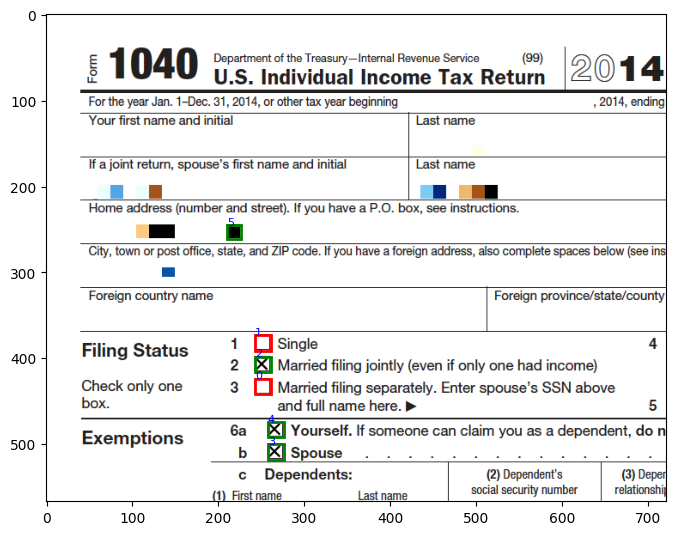

In [10]:
with open(file_path, 'rb') as f:
    source_bytes = f.read()
b64_source_bytes_as_str = base64.b64encode(source_bytes).decode("utf-8")
image = Image.open(io.BytesIO(source_bytes))

json_request = {}
json_request["encoded_image"] = {"b64": b64_source_bytes_as_str}
if model_signature_has_key:
    json_request["key"] = "0"
prediction_response = aiplatform_predict_from_endpoint(
    project=project_id,
    endpoint_id=endpoint_id,
    location=location,
    instances=json_request
)
process_predictions(prediction_response, image)